<html>
<div>
  <span style="font-family: Poppins; font-size:30px; color: white;"> <br/> University of Tehran <br/> CA1
</div>
<span style="font-family: Poppins; font-size:15pt; color: white; vertical-align: middle;"> Mahdi Noori </span><br>
<span style="font-family: Poppins; font-size:15pt; color: white; vertical-align: middle;"> 810100231 </span>

</html>

## Goal
in this notebook we learn about genetic algorithms and how we can use them to find results when ordinary search algorithms are not effective.

## Problem Description
in this problem we are given several points coordinations on a 2D surface and we should find a polynomial which best fits the given points. we have some other constraints mentioned below :
- the degree of polynomial will be given as inputs 
- each coefficient has a constraint which will be given


as a example we would have :<br>

a = [0, 1] , b = [1, 0] , c = [2, -5] , d = [-1, -8] as points and the equation would be $y=1+3x-5x^2+x^3$

In this algorithm we have an initial population which will evolve over time so that only the best remains.<br>


## Modeling
here we break each element into a class for ease of usage.
### Consts
Since we have lots of const variables like chance of mutation and so forth, I decided to store all of them in a class.

In [1]:
import random
from dataclasses import dataclass
from functools import  reduce
from math import  floor 
import numpy as np
from helper import calculate_mse,test_gen,curve_plot,create_equation
import matplotlib.pyplot as plt
@dataclass
class Consts:
    crossover_probability: float
    mutation_probability: float
    maximum_number_of_evolutions: int
    carry_percent: float
    chromosome_size: int
    population_size: int
    selection_weights: list[int]

## Input
I define a class for storing inputs of the problem. (mostly so we can distinguish the input variables from consts)

In [2]:
@dataclass
class Inputs:
    polynomial_degree: int
    num_of_points : int
        # index 0 : low_boundary
        # index 1 : up_boundary
    coefficients_boundary : list[int]
    points : list[tuple] 



## Data Initialization
Here I initialize constants and the inputs. Inputs are the same as the example in the CA pdf.<br>
(note that the constants can be set to other values later if they don't perform as expected)

In [3]:
POPULATION_SIZE=100

inputs=Inputs(
    polynomial_degree = 3,
    num_of_points = 4,
    coefficients_boundary=[-5,5],
    points=[(0,1),(1,0),(2,-5),(-1,-8)]
)

consts = Consts(
    crossover_probability = 0.6,
    mutation_probability = 0.2,
    chromosome_size = inputs.polynomial_degree+1,
    carry_percent = 0.2,
    maximum_number_of_evolutions = 1000,
    population_size = POPULATION_SIZE,
    selection_weights = [i for i in range(1,POPULATION_SIZE+1)],
)

### Chromosome
A chromosome is a individual in our population. Each chromosome has ```polynomial_degree + 1``` genes. Each gene keeps one of the coefficients for the equation. For example the 0th index holds the value of the constant of the equation. We define these function for class ```Chromosome``` :
 
- `__init__` initializes the fitness to 0. if there was any coeficients in the input argument assigns it else randomly generates them between the defined boundries

- `mutate` randomly changes a coefficient to another value between the defined boundries if the mutation_probability was met

- `crossover` takes another chromosome and then randomly chooses a point for crossover and then returns the two new chromosomes (here i am using a one-point crossover but instead we could have used uniform crossover. the main difference between uniform crossover and one-point crossover is in the way they exchange genes. Uniform crossover allows for a random selection of genes, while one-point crossover exchanges genes at a specific crossover point, preserving the relative order of genes)
- `calc_fitness` calculates the fitness of chromosome to see how well the chromosome performs. here i am using MSE for fitness. (actually i am calculating error :) meaning that the higher the fitness gets the lower the chromosome performed ) 

In [4]:
class Chromosome:
    def __init__(self, coefficients = None) -> None:
        self.fitness = 0
        self.coefficients = coefficients if coefficients else [random.randrange(inputs.coefficients_boundary[0],inputs.coefficients_boundary[1]) \
             for _ in range(consts.chromosome_size)]
        self.coefficients[-1]=self.coefficients[-1] if self.coefficients[-1] != 0 \
             else random.choice([num for num in range(inputs.coefficients_boundary[0], inputs.coefficients_boundary[1] + 1) if num != 0])

    def mutate(self) -> None:
        if random.random() < consts.mutation_probability:
            self.coefficients[random.randint(0, consts.chromosome_size - 1)] = random.randrange(inputs.coefficients_boundary[0],inputs.coefficients_boundary[1])
            self.coefficients[-1]=self.coefficients[-1] if self.coefficients[-1] != 0 \
             else random.choice([num for num in range(inputs.coefficients_boundary[0], inputs.coefficients_boundary[1] + 1) if num != 0])
        
            
    def crossover(self, other):
        first_child_coefficients = self.coefficients
        second_child_coefficients = other.coefficients
        if random.random() < consts.crossover_probability:
            crossover_point = random.randrange(0, consts.chromosome_size - 1)
            first_child_coefficients = other.coefficients[crossover_point:]+self.coefficients[:crossover_point] 
            second_child_coefficients = self.coefficients[crossover_point:]+other.coefficients[:crossover_point] 
            
        return Chromosome(first_child_coefficients) ,Chromosome(second_child_coefficients) 

    
    def calc_fitness(self) -> None:
        x_list=[point[0] for point in inputs.points]
        y_list=[point[1] for point in inputs.points]
        y_hat_list=[]
        for x in x_list:
            y_hat=0
            for i,coff in enumerate(self.coefficients):
                y_hat+=coff*(x**i)
            y_hat_list.append(y_hat)
        
        self.fitness=calculate_mse(y_hat_list,y_list)

### calculate_mse
As i mentioned eralier i use MSE to calculate the fitness. The formula is :<br>

$$MSE = \frac{1}{n}\sum_{i=1}^{n} (Y_i-\hat{Y_i})^2$$

where $Y$ is the actual y-coordinate of points and $\hat{Y}$ is the prediction of our algorithm and $n$ is the size of them

I implemented this function in ```helper.py```. It recieves ```targets``` and ```predictions``` and then calculates the MSE.

You can see the function below :
  ```python
   def calculate_mse(predictions, targets):
    squared_errors = [(predict - target) ** 2 for predict, target in zip(predictions, targets)]
    mse = sum(squared_errors) / len(predictions)
    return mse
   ```

## Population
The whole population which is consists of many chromosomes. It shows the world which we have now till next evolution.We define these function for class ```Population``` :

- `__init__` initializes the num_of_generation to 1. creates ```population_size``` chromosomes and then make them to calculate their fitness so i can use them later

- `mutate` does the evolution act. first i sort the chromosomes by fitness. then i define the next generation using this formula :<br><br>
$next generation = carry on chromosomes + others $<br><br>
$carry on chromosomes = carry percent * population size$<br><br>
in this context $carry on chromosomes$ is the top ```carry_percent``` individuals from the previous generation and $others$ are the chromosomes which get generated using crossover and mutation.<br><br>
the other trick here is that after the crossover and mutation we have two new chromosomes but we take the one with better fitness to the next generation. for selecting the parents i am using rank based selection and weights so the probability of the parents belonging to better individuals society increases.

- `genetic_algorithm` runs the algorithm for ```maximum_number_of_evolutions``` generations or when the best candidate of a generation has fitness less than one and then returns the chromosome with lowest fitness

In [20]:
class Population:
    def __init__(self) -> None:
        self.chromosomes = [Chromosome() for _ in range(consts.population_size)]
        for x in self.chromosomes:
            x.calc_fitness()
        self.num_of_generations = 1
    
    def evolve(self) -> None:
        self.chromosomes.sort(key = lambda x: x.fitness ,reverse=True)
        carry_size=floor((consts.carry_percent)*consts.population_size)

        next_generation = [None for _ in range(consts.population_size)]
        next_generation[:carry_size]=self.chromosomes[len(self.chromosomes)-carry_size:]
        for i in range(len(self.chromosomes)-carry_size):
            first_parent = random.choices(self.chromosomes, consts.selection_weights)[0]
            second_parent = random.choices(self.chromosomes, consts.selection_weights)[0]
            first_child,second_child = first_parent.crossover(second_parent)
            first_child.mutate()
            second_child.mutate()
            next_generation[i+carry_size] = first_child if first_child.fitness>second_child.fitness else second_child
        
        self.chromosomes = next_generation
  
    
    def genetic_algorithm(self,verbose=False):
        answer=min(self.chromosomes,key=lambda x : x.fitness)
        while self.num_of_generations <= consts.maximum_number_of_evolutions and answer.fitness >0:
            if (verbose):
                print(f"the best mse in generation number { self.num_of_generations } is : { answer.fitness }")
            
            self.evolve()
            self.num_of_generations += 1
            for x in self.chromosomes:
                x.calc_fitness()
            
            answer=min(self.chromosomes,key=lambda x : x.fitness)
            
        answer=min(self.chromosomes,key=lambda x : x.fitness)
        if (verbose):
            print(f"The algorithm fitted the curve with { create_equation(answer.coefficients[::-1])} equation in {self.num_of_generations-1} generation with mse of {answer.fitness}")
        return answer

### Some Explanation
in the ```Population``` class i carried top individuals because it improves optimization by maintaining good solutions, accelerating convergence, and balancing robustness.
in the other part using a rnked based selection reduces sensitivity to fitness scaling and promotes diversity.
also picking the better child will result in a faster convergence but also it can reduce the diversity.


## Testing
I define two functions in ```helper.py``` for testing.
- `test_gen` generates a set of points using the desired coefficients for the polynomial equation
- `curve_plot` used to plot the predicted curve against the input points

## Example Run
First we test it on the provided example

the best mse in generation number 1 is : 3.5
the best mse in generation number 2 is : 3.5
the best mse in generation number 3 is : 2.5
the best mse in generation number 4 is : 2.5
the best mse in generation number 5 is : 2.5
the best mse in generation number 6 is : 2.5
the best mse in generation number 7 is : 2.5
the best mse in generation number 8 is : 3.5
the best mse in generation number 9 is : 3.5
the best mse in generation number 10 is : 3.5
the best mse in generation number 11 is : 3.5
the best mse in generation number 12 is : 3.5
the best mse in generation number 13 is : 3.5
the best mse in generation number 14 is : 3.5
the best mse in generation number 15 is : 3.0
the best mse in generation number 16 is : 1.5
the best mse in generation number 17 is : 1.5
the best mse in generation number 18 is : 1.5
the best mse in generation number 19 is : 1.0
the best mse in generation number 20 is : 1.0
the best mse in generation number 21 is : 1.0
the best mse in generation number 22 is : 1

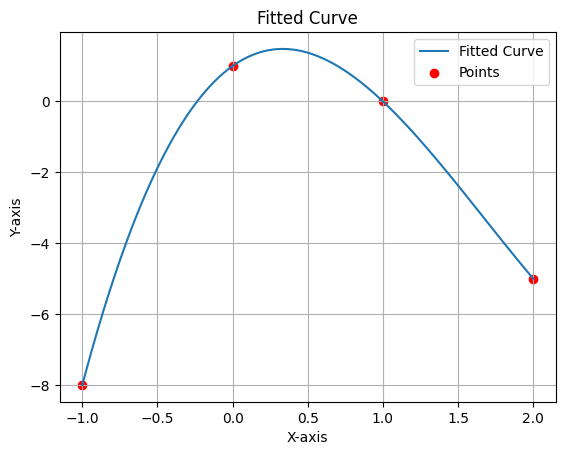

In [17]:
population = Population()
    
res = population.genetic_algorithm(verbose=True)
curve_plot(res.coefficients,inputs.points)

we try to find the best consts in this part.

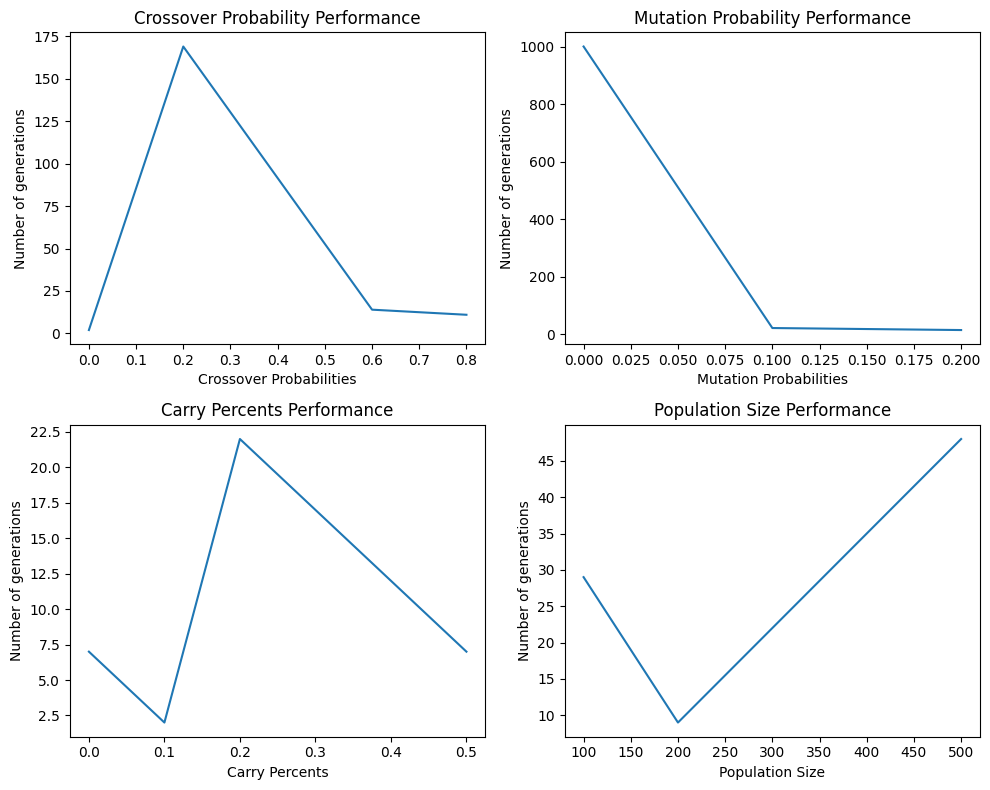

In [20]:
crossover_probabilities=[0 , 0.2 , 0.6 , 0.8]
mutation_probabilities=[0 , 0.1 , 0.2]
carry_percents=[0 , 0.1 , 0.2 , 0.5]
population_sizes=[100 , 200 , 500]
keywords=["crossover_probabilities","mutation_probabilities","carry_percents","population_sizes"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

results=[]
for crossover_probability in crossover_probabilities:
    consts.crossover_probability=crossover_probability
    population = Population()
    res = population.genetic_algorithm(verbose=False)
    results.append(population.num_of_generations)
axes[0, 0].plot(crossover_probabilities, results)
axes[0, 0].set_xlabel('Crossover Probabilities')
axes[0, 0].set_ylabel('Number of generations')
axes[0, 0].set_title('Crossover Probability Performance')
consts.crossover_probability=0.6

results=[]
for mutation_probability in mutation_probabilities:
    consts.mutation_probability=mutation_probability
    population = Population()
    res = population.genetic_algorithm(verbose=False)
    results.append(population.num_of_generations)
axes[0, 1].plot(mutation_probabilities, results)
axes[0, 1].set_xlabel('Mutation Probabilities')
axes[0, 1].set_ylabel('Number of generations')
axes[0, 1].set_title('Mutation Probability Performance')
consts.mutation_probability=0.2

results=[]
for carry_percent in carry_percents:
    consts.carry_percent=carry_percent
    population = Population()
    res = population.genetic_algorithm(verbose=False)
    results.append(population.num_of_generations)
axes[1,0].plot(carry_percents, results)
axes[1,0].set_xlabel('Carry Percents')
axes[1,0].set_ylabel('Number of generations')
axes[1,0].set_title('Carry Percents Performance')
consts.carry_percent=0.2

results=[]
for ps in population_sizes:
    consts.population_size = ps
    consts.selection_weights = [i for i in range(1,ps+1)]
    population = Population()
    res = population.genetic_algorithm(verbose=False)
    results.append(population.num_of_generations)
axes[1, 1].plot(population_sizes, results)
axes[1, 1].set_xlabel('Population Size')
axes[1, 1].set_ylabel('Number of generations')
axes[1, 1].set_title('Population Size Performance')

    
plt.tight_layout()
plt.show()

As we can see above the best values have been shown.
now let's test the algorithm with these values.

the best mse in generation number 1 is : 2.0
the best mse in generation number 2 is : 2.0
the best mse in generation number 3 is : 2.0
the best mse in generation number 4 is : 2.0
the best mse in generation number 5 is : 2.0
the best mse in generation number 6 is : 2.0
the best mse in generation number 7 is : 2.0
the best mse in generation number 8 is : 2.0
the best mse in generation number 9 is : 2.0
the best mse in generation number 10 is : 2.0
the best mse in generation number 11 is : 2.0
the best mse in generation number 12 is : 2.0
the best mse in generation number 13 is : 2.0
the best mse in generation number 14 is : 1.0
the best mse in generation number 15 is : 1.0
the best mse in generation number 16 is : 1.0
the best mse in generation number 17 is : 1.0
the best mse in generation number 18 is : 1.0
the best mse in generation number 19 is : 1.0
the best mse in generation number 20 is : 1.0
the best mse in generation number 21 is : 1.0
the best mse in generation number 22 is : 1

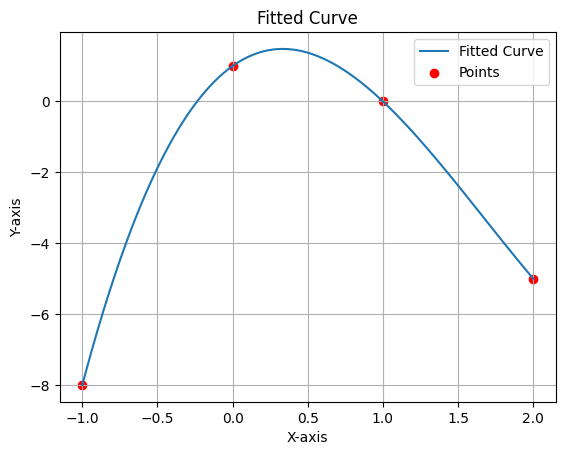

In [22]:
consts = Consts(
    crossover_probability = 0.8,
    mutation_probability = 0.2,
    chromosome_size = inputs.polynomial_degree+1,
    carry_percent = 0.1,
    maximum_number_of_evolutions = 1000,
    population_size = 200,
    selection_weights = [i for i in range(1,200+1)],
)

population = Population()
    
res = population.genetic_algorithm(verbose=True)
curve_plot(res.coefficients,inputs.points)

As we can see the algorithm performs better. but we should note that because this is a random algorithm it may not always do the best with the best consts.

some other tests with different inputs generated by ```test_gen``` function.

the best mse in generation number 1 is : 4567.857142857143
the best mse in generation number 2 is : 4567.857142857143
the best mse in generation number 3 is : 168.57142857142858
the best mse in generation number 4 is : 168.57142857142858
the best mse in generation number 5 is : 168.57142857142858
the best mse in generation number 6 is : 168.57142857142858
the best mse in generation number 7 is : 25.0
the best mse in generation number 8 is : 25.0
the best mse in generation number 9 is : 25.0
the best mse in generation number 10 is : 25.0
the best mse in generation number 11 is : 20.571428571428573
the best mse in generation number 12 is : 17.714285714285715
the best mse in generation number 13 is : 17.714285714285715
the best mse in generation number 14 is : 17.714285714285715
the best mse in generation number 15 is : 17.714285714285715
the best mse in generation number 16 is : 17.714285714285715
the best mse in generation number 17 is : 17.714285714285715
the best mse in generation num

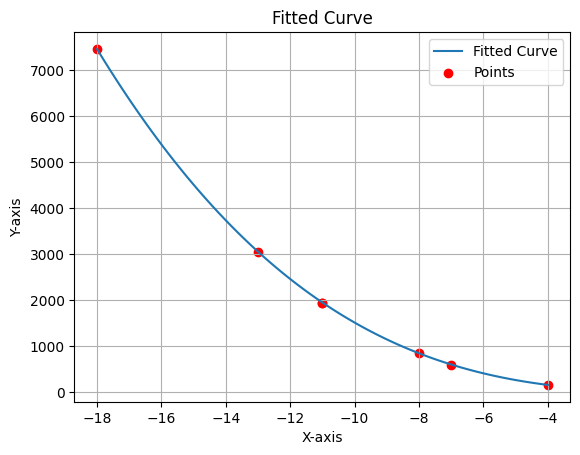

In [25]:
inputs=Inputs(
    polynomial_degree = 3,
    num_of_points = 7,
    coefficients_boundary=[-10,10],
    points=test_gen([6,0,5,-1],7)
)

consts.chromosome_size=inputs.polynomial_degree+1

population = Population()
    
res = population.genetic_algorithm(verbose=True)
curve_plot(res.coefficients,inputs.points)

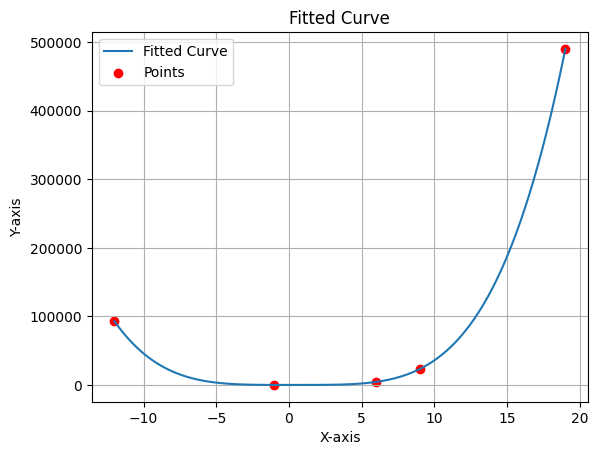

In [27]:
inputs=Inputs(
    polynomial_degree = 4,
    num_of_points = 5,
    coefficients_boundary=[-10,10],
    points=test_gen([3,1,9,-5,4],5)
)
consts.chromosome_size=inputs.polynomial_degree+1
population = Population()
    
res = population.genetic_algorithm()
curve_plot(res.coefficients,inputs.points)

the best mse in generation number 1 is : 18.0
the best mse in generation number 2 is : 6.666666666666667
the best mse in generation number 3 is : 1.0
the best mse in generation number 4 is : 1.0
the best mse in generation number 5 is : 1.0
the best mse in generation number 6 is : 1.0
the best mse in generation number 7 is : 0.3333333333333333
the best mse in generation number 8 is : 1.0
the best mse in generation number 9 is : 1.0
the best mse in generation number 10 is : 1.0
the best mse in generation number 11 is : 0.3333333333333333
the best mse in generation number 12 is : 0.3333333333333333
the best mse in generation number 13 is : 0.3333333333333333
the best mse in generation number 14 is : 0.3333333333333333
the best mse in generation number 15 is : 0.3333333333333333
the best mse in generation number 16 is : 0.3333333333333333
the best mse in generation number 17 is : 0.3333333333333333
the best mse in generation number 18 is : 0.3333333333333333
the best mse in generation numb

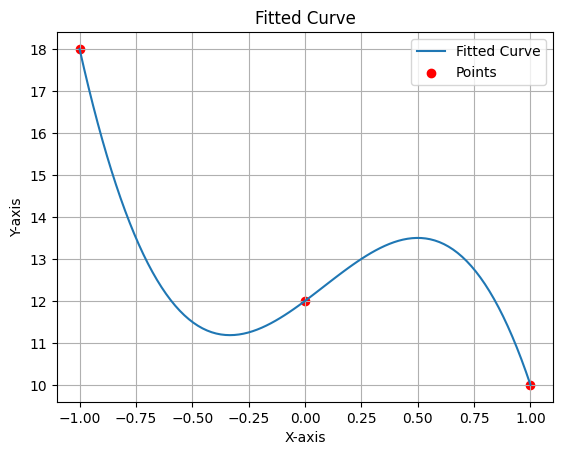

In [37]:
POPULATION_SIZE=200

inputs=Inputs(
    polynomial_degree = 3,
    num_of_points = 3,
    coefficients_boundary=[-15,15],
    points=[(0,12),(-1,18),(1,10)]
)

consts = Consts(
    crossover_probability = 0.6,
    mutation_probability = 0.2,
    chromosome_size = inputs.polynomial_degree+1,
    carry_percent = 0.1,
    maximum_number_of_evolutions = 10000,
    population_size = POPULATION_SIZE,
    selection_weights = [i for i in range(1,POPULATION_SIZE+1)],
)
population = Population()
    
res = population.genetic_algorithm(verbose=True)
curve_plot(res.coefficients,inputs.points)

the best mse in generation number 1 is : 4.666666666666667
the best mse in generation number 2 is : 4.333333333333333
the best mse in generation number 3 is : 3.0
the best mse in generation number 4 is : 2.0
the best mse in generation number 5 is : 1.6666666666666667
the best mse in generation number 6 is : 1.6666666666666667
the best mse in generation number 7 is : 0.6666666666666666
the best mse in generation number 8 is : 0.6666666666666666
the best mse in generation number 9 is : 0.6666666666666666
the best mse in generation number 10 is : 0.3333333333333333
the best mse in generation number 11 is : 0.3333333333333333
the best mse in generation number 12 is : 0.3333333333333333
the best mse in generation number 13 is : 0.3333333333333333
the best mse in generation number 14 is : 0.3333333333333333
the best mse in generation number 15 is : 0.3333333333333333
the best mse in generation number 16 is : 0.3333333333333333
the best mse in generation number 17 is : 0.3333333333333333
the 

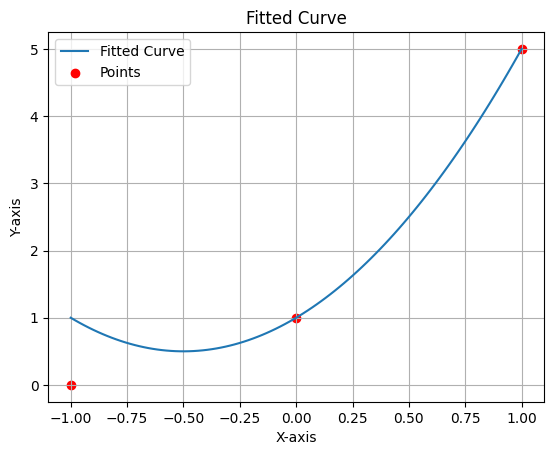

In [38]:
POPULATION_SIZE=200

inputs=Inputs(
    polynomial_degree = 2,
    num_of_points = 3,
    coefficients_boundary=[-10,10],
    points=[(0,1),(-1,0),(1,5)]
)

consts = Consts(
    crossover_probability = 0.6,
    mutation_probability = 0.2,
    chromosome_size = inputs.polynomial_degree+1,
    carry_percent = 0.1,
    maximum_number_of_evolutions = 1000,
    population_size = POPULATION_SIZE,
    selection_weights = [i for i in range(1,POPULATION_SIZE+1)],
)
population = Population()
    
res = population.genetic_algorithm(verbose=True)
curve_plot(res.coefficients,inputs.points)

## Conclusion

Genetic algorithms proved effective for curve fitting problems by efficiently exploring the solution space and finding optimal or near-optimal solutions. The choice of genetic operators and fitness function significantly impacted performance. Despite not guaranteeing global optimality, genetic algorithms are flexible, adaptable, and applicable to various curve types

## Questions

### Q1
  If population is too small:
  - the algorithm may not be able to explore the search space effectively and the algorithm may converge on a sub optimal solution 
  - the diversity in genes decreases and low diversity may cause loss of crucial info
  - because the population size is small we need to run the generations more to reach better solution so we otherwise it may result in a sub optimal solution

  If the population is too big:
  - we need more computational resources 
  - it will result in having redundant genes    

### Q2
  As we increase the population size in each generation we get a more diverse generation with more abillity to explore which will result in more robustness against getting stuck in a local optima. so it will result in more percise algorithm. on the other hand the algorithm needs more computational power so it will result in a slower convergence or even not converging

### Q3 
  Crossover :
  - increase the diversity and exploration area
  - used when we want to create better chromosome from two good ones from previous generation
  
  Mutation :
  - increase the diversity and exploration area
  - used when we want to get away from a sub optimal point
  
  It is likely to reach a solution using only one of them but it might not be as good as using both.
  because using only crossover may result in us getting stuck in a suboptimal solution and using only mutation may result in our algorithm takes much longer to find the solution because we are losing a lot of diversity. 

### Q4
- optimization for fitness function
- carry top individuals of previous generation to next generation
- increasing the population size for more diverse generation and more options to pick
- removing worst individuals from generation
- pick the best rates for crossover_probability and mutation_probability 
- if the hardware allows using parallelized computation

### Q5
The reason of this phenomennon is that the we get into a local optima rather than the global one.
this situation causes two problems. first is that we lose the abillity to explore more and the second one is that it requires more time to convrge.
there are two solutions:
- using mutation
- start the algorithm from different points

### Q6
Set a limit for number of generations so if there was no solution it stops

### Q7
Some of the mutation and crossover operations may result in time increases exponentialy. but in a normal way it will increase the algorithm time linearly.
The other problem that we may face is that the increase in degree of polynomial will cause the MSE exponential function to work slower and may result in a $O(n^2)$ increase. (this depends on the implementation of the MSE part)<br>
In conclusion this act will result in a slower run with more memory consumed.

### Q8
As the number of points increases we have to use more points for calculating fitness so it may take longer to find the solution but because we have more points to check we can fit a better curve.
